# Consigna 
- **3.1**: Con los datos de Facebook, computar la matriz de similaridad con producto interno
de la matriz de atributos, proponer un umbral u y construir un grafo conectando
los nodos que superan ese umbral. 
- **3.2**: Queremos comparar la red de amistades original y la construida a partir de los
datos. Proponer alguna forma para compararlas o utilizar alguna de estas opciones.
Comparar las redes mediante la correlacion de las matrices de adyacencia estiradas
(flatten). Comparar utilizando la correlacion entre las listas de autovalores.
- **3.3**: Realizar el procedimiento anterior para suficientes valores de umbral y buscar el
valor optimo que genera la red de atributos mas similar al grafo de amistades.
- **3.4**: Filtrar la matriz de atributos utilizando PCA: Computar la matriz de covarianza,
luego los autovectores. Seleccionar k componentes principales y proyectar los datos
al nuevo espacio. Repetir el punto anterior para varios valores de k y varios valores
de u. Analizar los resultados. 

## Consigna informal 

- Se cuenta con un archivo que indica en cada fila si dos usuarios son amigos entre sí y con un archivo que para cada usuario indica si tiene un atributo o no (no está muy clara la info de qué son esos atributos).
- Queremos poder construir grafos a partir de esos atributos, por ejemplo si dos personas tienen muchos atributos en común deberían estar conectadas.
- Luego queremos comparar los grafos reales con los hechos por atributos y ver como podemos optimizar algunos parámetros para que esos gráfos se parezcan. 
- La idea es usar PCA en un momento para procesar los atributos, para esto pueden utilizar python.
- La consigna es la misma con y sin PCA, pensalo como qué tenés que repeterir la búsqueda de umbral para sinPCA, PCAk=1, PCAk=2, etc, con k variando en un rango interesante, tipo k=1:10, y luego saltos exponenciales quizás
-  Se busca medir la correlación entre los valores en A y los valores de una nueva matriz de adyacencia obtenida a partir de los atributos F pasados por PCA. 

Por ejemplo, el siguiente gráfico muestra el valor de la correlación para distintos umbrales utilizados para calcular la nueva matriz de adyacencia, y también distintas cantidad de componentes principales 

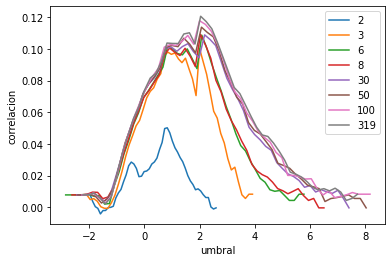

# Resolucion 

## Importaciones y Definiciones 

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget https://snap.stanford.edu/data/facebook.tar.gz
!tar xf facebook.tar.gz

--2023-10-17 15:58:50--  https://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘facebook.tar.gz.1’

facebook.tar.gz.1   100%[===================>] 714,95K   166KB/s    in 4,3s    

2023-10-17 15:58:55 (166 KB/s) - ‘facebook.tar.gz.1’ saved [732104/732104]



In [2]:
# Red de Amistad 786x786
G = nx.read_edgelist('facebook/1684.edges')
A = nx.to_numpy_array(G)

# Matriz de Atributos 786x319
F = np.loadtxt('facebook/1684.feat')
df = pd.DataFrame(F).set_index(0)
F = df.loc[list(map(int,G.nodes()))].values

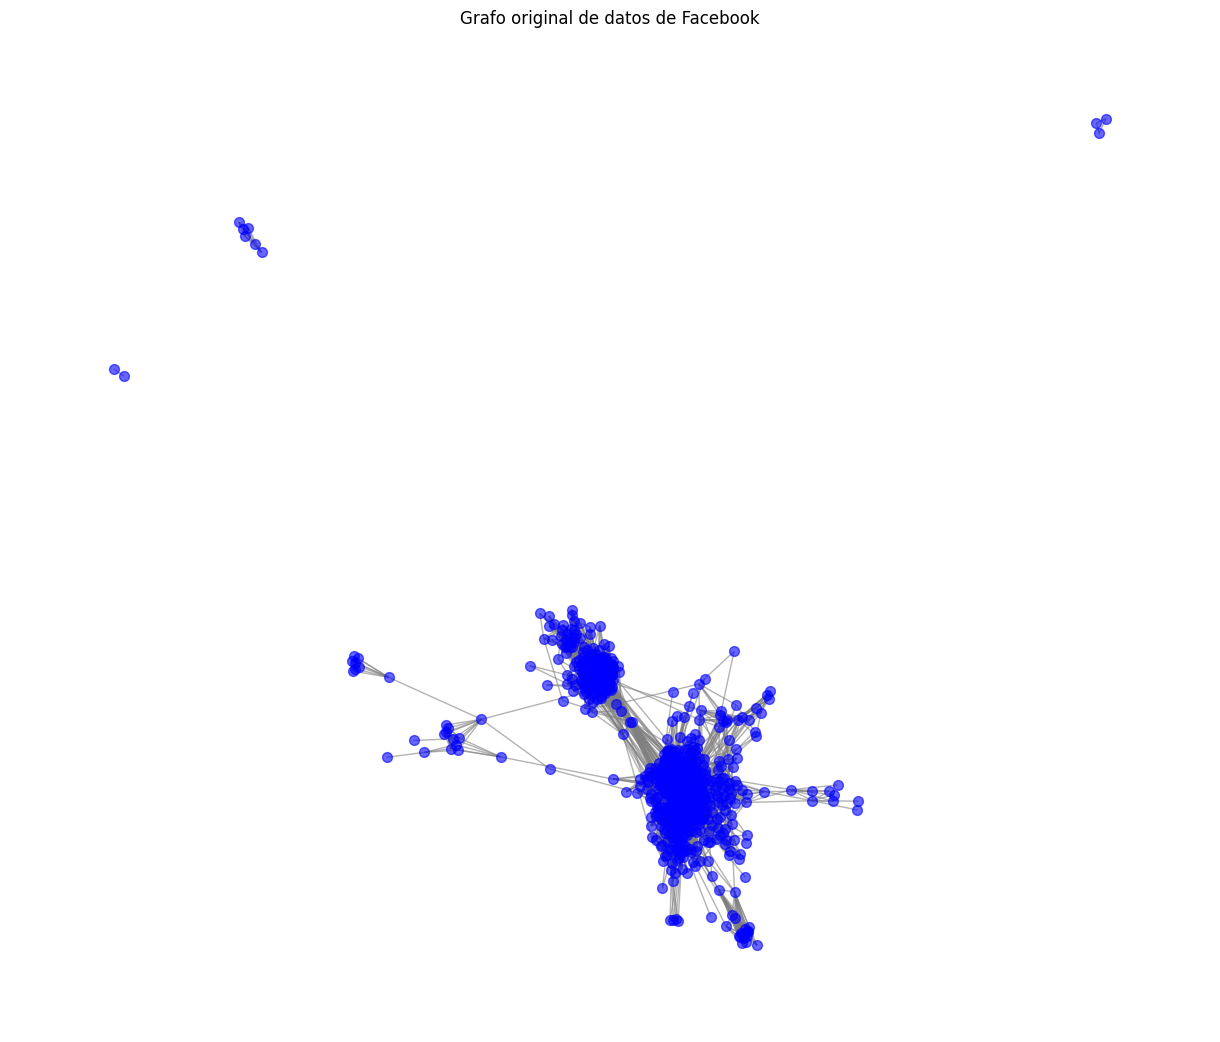

In [6]:
# Dibujar el grafo original
plt.figure(figsize=(12, 10))
nx.draw(G, with_labels=False, node_size=50, node_color='blue', edge_color='gray', alpha=0.6)
plt.title("Grafo original de datos de Facebook")
plt.show()

## 3.1.

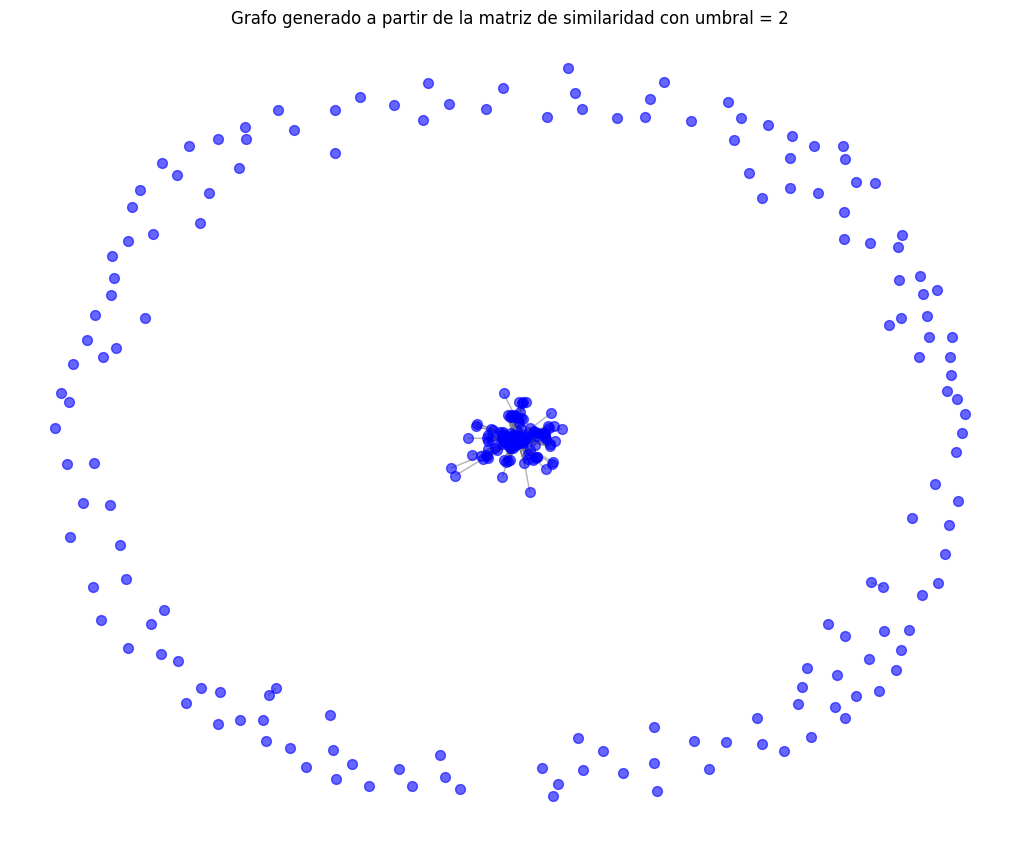

In [10]:
# Computo la matriz de similaridad como producto interno de la matriz de atributos 
# y construyo grafo a partir de un umbural u. 

def crear_grafo_desde_similaridad(F, u):
    matrizSimilaridad = F.dot(F.T)
    num_nodos = matrizSimilaridad.shape[0]
    grafo = nx.Graph()
    
    # Añadir nodos al grafo
    grafo.add_nodes_from(range(num_nodos))
    
    # Añadir aristas basadas en el umbral
    for i in range(num_nodos):
        for j in range(i + 1, num_nodos):  # Para evitar repetir pares y auto-conexiones
            if matrizSimilaridad[i, j] > u:
                grafo.add_edge(i, j)
                
    return grafo

umbral = 2
# Crear el grafo
grafo_matriz_similaridad = crear_grafo_desde_similaridad(F, umbral)

# Dibujar el grafo
plt.figure(figsize=(10, 8))
nx.draw(grafo_matriz_similaridad, with_labels=False, node_size=50, node_color='blue', edge_color='gray', alpha=0.6)
plt.title("Grafo generado a partir de la matriz de similaridad con umbral = {}".format(umbral))
plt.show()